# Introducció a la pràctica de Cas Kaggle

## Objectius

Els objectius d'aquesta pràctica són:

* BLABLABLABLA: 
    1. BLABLABLABLABLABLABLABLABLABLABLABLABLABLABLABLA.
    2. BLABLABLABLABLABLABLABLABLABLABLABLABLABLABLABLA
    3. BLABLABLABLABLABLABLABLABLABLABLABLABLABLABLABLA
    4. BLABLABLABLABLABLABLABLABLABLABLABLA

* BLABLABLABLABLABLABLABLA

* BLABLABLABLABLABLABLABLABLABLABLABLABLABLABLABLA

In [4]:
import math
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt
%matplotlib inline

# IMPORTS LINEAR REGRESSION
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score
# from mpl_toolkits.mplot3d import axes3d, Axes3D

# IMPORTS DATA CLASSIFICATION:
#from sklearn.linear_model import LogisticRegression
#from sklearn import svm, datasets
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc


# Apartat (C): Analitzant Dades

In [12]:
pokemon_dataset = pd.read_csv('PokeTypeMatchupData.csv', header=0, delimiter=',')
pokemon_data = pokemon_dataset.values

x = pokemon_data[:, :2]
y = pokemon_data[:, 2]

print("Dimensionalitat de la BBDD:", pokemon_dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Dimensionalitat de la BBDD: (576, 20)
Dimensionalitat de les entrades X (576, 2)
Dimensionalitat de l'atribut Y (576,)


In [11]:
pokemon_dataset.head() 

,Name,Number,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
0,Bulbasaur,#001,*1,*2,*0.5,*0.5,*0.25,*2,*0.5,*1,*1,*2,*2,*1,*1,*1,*1,*1,*1,*0.5
1,Ivysaur,#002,*1,*2,*0.5,*0.5,*0.25,*2,*0.5,*1,*1,*2,*2,*1,*1,*1,*1,*1,*1,*0.5
2,Venusaur,#003,*1,*2,*0.5,*0.5,*0.25,*2,*0.5,*1,*1,*2,*2,*1,*1,*1,*1,*1,*1,*0.5
3,Charmander,#004,*1,*0.5,*2,*1,*0.5,*0.5,*1,*1,*2,*1,*1,*0.5,*2,*1,*1,*1,*0.5,*0.5
4,Charmeleon,#005,*1,*0.5,*2,*1,*0.5,*0.5,*1,*1,*2,*1,*1,*0.5,*2,*1,*1,*1,*0.5,*0.5


In [13]:
print(pokemon_dataset.isnull().sum())

Name        0
Number      0
Normal      0
Fire        0
Water       0
Electric    0
Grass       0
Ice         0
Fighting    0
Poison      0
Ground      0
Flying      0
Psychic     0
Bug         0
Rock        0
Ghost       0
Dragon      0
Dark        0
Steel       0
Fairy       0
dtype: int64


In [15]:
pokemon_dataset.describe()

,Name,Number,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
count,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576,576
unique,576,540,3,5,5,6,5,5,6,6,5,5,6,5,5,5,4,5,5,5
top,Bulbasaur,#479,*1,*1,*1,*1,*1,*1,*1,*1,*1,*1,*1,*1,*1,*1,*1,*1,*1,*1
freq,1,6,462,263,315,299,227,265,220,330,320,351,359,260,319,368,457,360,301,368


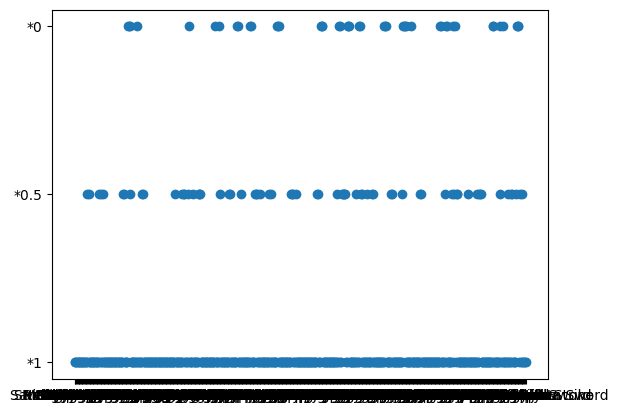

In [24]:
# mostrem atribut 0
plt.figure()

ax = plt.scatter(x[:,0], y)